In [1]:
import os
import time
import numpy as np
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
from datetime import datetime

# Utils

In [160]:
import polars as pl
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, RobustScaler 

class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name=None, features_type='M', batch_size=64):
        if offset < label_size:
            print(f"Offset will be changed from {offset} to {label_size}")
            offset = label_size

        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size
        self.scaler = MinMaxScaler()

        # Load the data
        self.df = pl.read_excel(file_path)
        self.df = self.df[['<CloseFixed>', '<Volume>']]
        if date_column is not None:
            self.df = self.df.drop('date time')

        # Standardize the 'Close' column
        if '<CloseFixed>' in self.df.columns:
            close_values = self.df.select('<CloseFixed>').to_numpy()
            scaled_close = self.scaler.fit_transform(close_values)
            self.df = self.df.with_columns(pl.Series('<CloseFixed>', scaled_close.flatten()))
            volume_values = self.df.select('<Volume>').to_numpy()
            scaled_volume = self.scaler.fit_transform(volume_values)
            self.df = self.df.with_columns(pl.Series('<Volume>', scaled_volume.flatten()))

        # Determine in_variable and out_variable based on features_type
        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError("Invalid features_type. Choose from 'S' for Univariate-to-Univariate, 'M' for Multivariate-to-Multivariate, 'MS' for Multivariate-to-Univariate.")

        # Preprocess the data
        self.X_train, self.y_train = self.__create_dataset(0, int(train_size * len(self.df)))
        print(f'{self.X_train.shape = }')
        print(f'{self.y_train.shape = }')
        self.X_val, self.y_val = self.__create_dataset(int(train_size * len(self.df)), int((train_size + val_size) * len(self.df)))
        print(f'{self.X_val.shape = }')
        print(f'{self.y_val.shape = }')
        self.X_test, self.y_test = self.__create_dataset(int((train_size + val_size) * len(self.df)), None)
        print(f'{self.X_test.shape = }')
        print(f'{self.y_test.shape = }')

        # Convert to PyTorch DataLoaders
        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)

    def fit(self):
        df = pl.read_excel(file_path)
        close_values = df.select('<CloseFixed>').to_numpy()
        fited = self.scaler.fit(close_values)
        return fited

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset

        start_idx += self.input_size + self.offset

        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError("Invalid features_type. Choose from 'S', 'M', 'MS'.")

            features.append(feature.to_numpy())
            labels.append(label.to_numpy())
            self.out_features = label.columns
            self.in_features = label.columns

        return np.array(features), np.array(labels)

    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).cuda()
        y_tensor = torch.tensor(y, dtype=torch.float32).cuda()
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)


In [161]:
import torch
import torch.nn as nn

class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.001, patience=100):
        self.model = model.cuda() if torch.cuda.is_available() else model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()  # Set the model to training mode
            total_train_loss = 0

            for inputs, targets in self.train_loader:
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_train_loss / len(self.train_loader)

            # Validate the model
            val_loss = self.evaluate(loader=self.val_loader)

            # Check for early stopping
            if self.early_stopping(val_loss, save_path):
                print(f"Early stopping at epoch {epoch + 1}")
                return

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'time: {int(time.time() - start_time)}s, '
                  f'loss: {avg_train_loss:.4f}, '
                  f'val_loss: {val_loss:.4f}')

        self.load_model(save_path)

    def evaluate(self, loader):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        return avg_loss

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')

    def predict(self, input_data):
        self.model.eval()  # Set the model to evaluation mode

        if isinstance(input_data, DataLoader):
            # If input_data is a DataLoader, iterate through batches and concatenate predictions
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            # Assume input_data is a single input tensor
            with torch.no_grad():
                predictions = self.model(input_data).unsqueeze(0)

        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None:
            feature_names = [f'Feature {i + 1}' for i in range(y.shape[2])]

        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10, 5))

            plt.plot(y[:, :, feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:, :, feature_index].flatten(), label='y_hat', linestyle='--')

            plt.title(feature_name)
            plt.xlabel('Time Step')
            plt.ylabel('Values')
            plt.legend()

            if save_plots:
                # Create the save directory if it doesn't exist
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)

                # Save the plot
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name[1:-1]}.png')
                plt.savefig(save_path)

            plt.show()
            plt.close()  # Close the plot to avoid overlapping in saved images

class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval

    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)

    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f'Model saved to {save_path}')

    def train(self, save_dir='.'):
        self.model.fit(self.preprocessing(self.xtrain),
                       self.preprocessing(self.ytrain),
                       eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pkl')
        self.save_model(save_path=save_path)

    def predict(self, x):
        return self.model.predict(self.preprocessing(x))

    def evaluate(self, x, y):
        from sklearn.metrics import mean_squared_error
        # print(self.preprocessing(y).shape)
        # print(self.predict(self.preprocessing(x)).shape)
        return mean_squared_error(self.preprocessing(y), self.predict(self.preprocessing(x)))

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plot(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

# Models

In [128]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)  # Adjust for output sequence length
        self.ahead = ahead
        self.output_size = output_size

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Reshape from [batch, lag, features] to [batch, lag * features]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)  # Reshape to [batch, ahead, features]

In [129]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # RNN Layer - can be replaced with nn.LSTM or nn.GRU
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [130]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)#, dropout=0.2)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [131]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)#, dropout=0.2)

        # Output layer
        # Output size is doubled because BiLSTM has two hidden states for each layer
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate BiLSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out


# Configs

In [173]:
input_size = 48
label_size = 1
offset = 1
train_size = 0.85
val_size = 0.1
num_epochs = 1_000_000
patience = 20
learning_rate = 0.0005
hidden_size = 64
num_layers = 2
ele = 200
target_name = '<CloseFixed>'
date_column = 'date time'
file_path = 'C:\\Users\\Admin\\AIO\\Multivariate Time Series Forecasting (LSTM)\\excel_vnindex.xlsx'
plot_dir = 'plots'
weight_dir = 'weights'
results = []

In [153]:
xgboost_config = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'n_estimators': num_epochs,
    'max_depth': 3,
    'learning_rate': 0.01,
    'early_stopping_rounds': patience
}

# **Univariate-to-Univartiate**

In [134]:
features_type='S'
sub_dir = 'uni2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
uni2uni_loader = TimeSeriesDataLoader(file_path,
                                      input_size=input_size,
                                      label_size=label_size,
                                      offset=offset,
                                      train_size=train_size,
                                      val_size=val_size,
                                      target_name=target_name,
                                      features_type=features_type,
                                      date_column=date_column)

self.X_train.shape = (4657, 48, 1)
self.y_train.shape = (4657, 1, 1)
self.X_val.shape = (505, 48, 1)
self.y_val.shape = (505, 1, 1)
self.X_test.shape = (226, 48, 1)
self.y_test.shape = (226, 1, 1)


In [135]:
inverse = uni2uni_loader.fit()
inverse

MinMaxScaler()

## MLP

In [136]:
MLP_uni2uni = MLP(input_size=uni2uni_loader.in_variable*input_size,
                  hidden_size=hidden_size,
                  output_size=uni2uni_loader.out_variable,
                  ahead=label_size)
MLP_uni2uni_manager = ModelManager(model=MLP_uni2uni,
                                   train_loader=uni2uni_loader.train_loader,
                                   val_loader=uni2uni_loader.val_loader,
                                   lr=learning_rate,
                                   patience=patience)
MLP_uni2uni_manager.train(num_epochs=num_epochs,
                          save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": MLP_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

Model saved to weights\uni2uni\best-MLP.pth
Epoch [1/1000000], time: 0s, loss: 0.0105, val_loss: 0.0009
Epoch [2/1000000], time: 0s, loss: 0.0012, val_loss: 0.0018
Epoch [3/1000000], time: 0s, loss: 0.0012, val_loss: 0.0018
Epoch [4/1000000], time: 0s, loss: 0.0012, val_loss: 0.0018
Epoch [5/1000000], time: 0s, loss: 0.0010, val_loss: 0.0017
Epoch [6/1000000], time: 0s, loss: 0.0009, val_loss: 0.0015
Epoch [7/1000000], time: 0s, loss: 0.0008, val_loss: 0.0012
Epoch [8/1000000], time: 0s, loss: 0.0007, val_loss: 0.0011
Model saved to weights\uni2uni\best-MLP.pth
Epoch [9/1000000], time: 0s, loss: 0.0006, val_loss: 0.0009
Model saved to weights\uni2uni\best-MLP.pth
Epoch [10/1000000], time: 0s, loss: 0.0005, val_loss: 0.0008
Model saved to weights\uni2uni\best-MLP.pth
Epoch [11/1000000], time: 0s, loss: 0.0005, val_loss: 0.0007
Model saved to weights\uni2uni\best-MLP.pth
Epoch [12/1000000], time: 0s, loss: 0.0005, val_loss: 0.0006
Model saved to weights\uni2uni\best-MLP.pth
Epoch [13/100

{'Name': 'MLP', 'Type': 'uni2uni', 'MSE': 0.0003730165844899602}

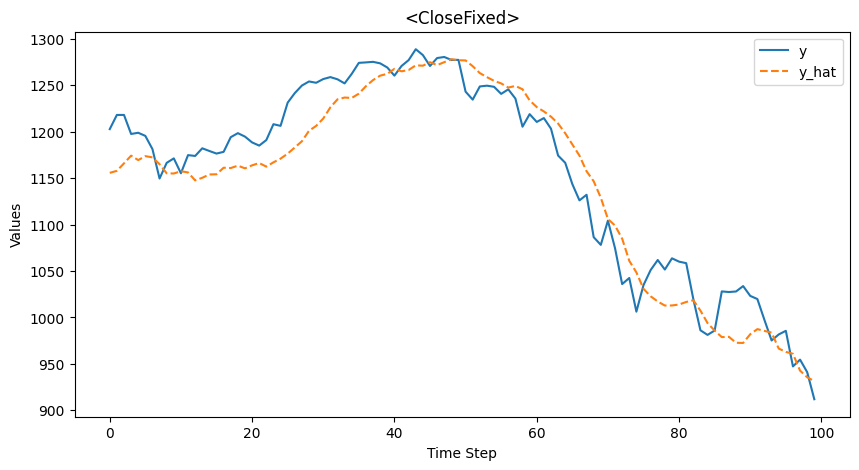

In [137]:
MLP_uni2uni_manager.plot(y=inverse.inverse_transform(uni2uni_loader.y_test.reshape(-1, uni2uni_loader.y_test.shape[-1])).reshape(-1, 1, 1),
                         yhat=inverse.inverse_transform(MLP_uni2uni_manager.predict(uni2uni_loader.test_loader).reshape(-1, uni2uni_loader.y_test.shape[-1]).cpu()).reshape(-1, 1, 1),
                         feature_names=uni2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

## LSTM

In [138]:
LSTM_uni2uni = LSTM(input_size=uni2uni_loader.in_variable,
                    hidden_size=hidden_size,
                    output_size=uni2uni_loader.out_variable,
                    ahead=label_size,
                    num_layers=num_layers)
print(LSTM_uni2uni)

LSTM_uni2uni_manager = ModelManager(model=LSTM_uni2uni,
                                    train_loader=uni2uni_loader.train_loader,
                                    val_loader=uni2uni_loader.val_loader,
                                    lr=learning_rate,
                                    patience=patience)
LSTM_uni2uni_manager.train(num_epochs=num_epochs,
                           save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": LSTM_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [1/1000000], time: 0s, loss: 0.0243, val_loss: 0.0209
Epoch [2/1000000], time: 0s, loss: 0.0557, val_loss: 0.1193
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [3/1000000], time: 0s, loss: 0.0284, val_loss: 0.0058
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [4/1000000], time: 0s, loss: 0.0194, val_loss: 0.0016
Epoch [5/1000000], time: 0s, loss: 0.0039, val_loss: 0.0024
Epoch [6/1000000], time: 0s, loss: 0.0018, val_loss: 0.0041
Epoch [7/1000000], time: 0s, loss: 0.0037, val_loss: 0.0028
Epoch [8/1000000], time: 0s, loss: 0.0009, val_loss: 0.0038
Epoch [9/1000000], time: 0s, loss: 0.0025, val_loss: 0.0033
Epoch [10/1000000], time: 0s, loss: 0.0005, val_loss: 0.0033
Epoch [11/1000000], time: 0s, loss: 0.0012, val_loss: 0.0032
Epoch [12/1000000], time: 0s, loss: 0.0004, val_loss: 0.0033
Epoch [13/1000000], ti

{'Name': 'LSTM', 'Type': 'uni2uni', 'MSE': 0.0002463968194206245}

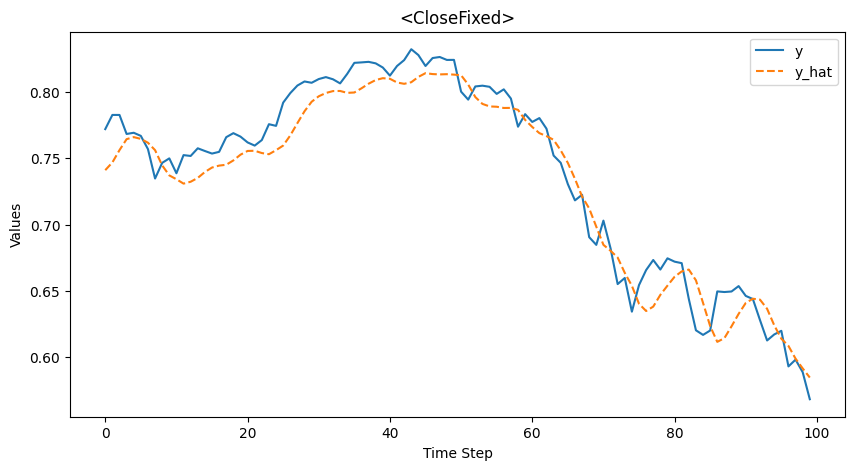

In [139]:
LSTM_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                          yhat=LSTM_uni2uni_manager.predict(uni2uni_loader.test_loader).cpu(),
                          feature_names=uni2uni_loader.out_features,
                          save_dir=os.path.join(plot_dir, sub_dir),
                          save_plots=True,
                          num_elements=ele)

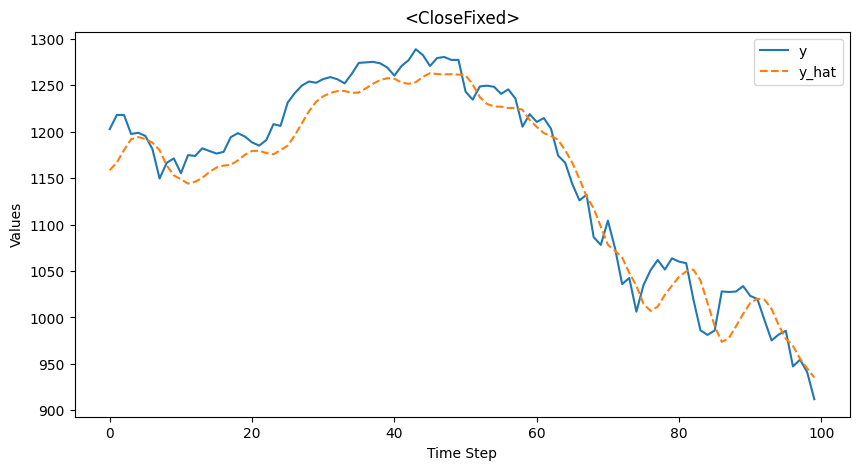

In [140]:
LSTM_uni2uni_manager.plot(y=inverse.inverse_transform(uni2uni_loader.y_test.reshape(-1, uni2uni_loader.y_test.shape[-1])).reshape(-1, 1, 1),
                         yhat=inverse.inverse_transform(LSTM_uni2uni_manager.predict(uni2uni_loader.test_loader).reshape(-1, uni2uni_loader.y_test.shape[-1]).cpu()).reshape(-1, 1, 1),
                         feature_names=uni2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

## BiLSTM

In [141]:
BiLSTM_uni2uni = BiLSTM(input_size=uni2uni_loader.in_variable,
                        hidden_size=hidden_size,
                        output_size=uni2uni_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)
BiLSTM_uni2uni_manager = ModelManager(model=BiLSTM_uni2uni,
                                      train_loader=uni2uni_loader.train_loader,
                                      val_loader=uni2uni_loader.val_loader,
                                      lr=learning_rate,
                                      patience=patience)
BiLSTM_uni2uni_manager.train(num_epochs=num_epochs,
                             save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": BiLSTM_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

Model saved to weights\uni2uni\best-BiLSTM.pth
Epoch [1/1000000], time: 0s, loss: 0.0228, val_loss: 0.0211
Epoch [2/1000000], time: 0s, loss: 0.0519, val_loss: 0.0697
Epoch [3/1000000], time: 0s, loss: 0.0320, val_loss: 0.0246
Model saved to weights\uni2uni\best-BiLSTM.pth
Epoch [4/1000000], time: 0s, loss: 0.0197, val_loss: 0.0004
Epoch [5/1000000], time: 0s, loss: 0.0059, val_loss: 0.0057
Epoch [6/1000000], time: 0s, loss: 0.0004, val_loss: 0.0007
Epoch [7/1000000], time: 0s, loss: 0.0005, val_loss: 0.0010
Epoch [8/1000000], time: 0s, loss: 0.0002, val_loss: 0.0010
Epoch [9/1000000], time: 0s, loss: 0.0003, val_loss: 0.0010
Epoch [10/1000000], time: 0s, loss: 0.0002, val_loss: 0.0011
Epoch [11/1000000], time: 0s, loss: 0.0003, val_loss: 0.0010
Epoch [12/1000000], time: 0s, loss: 0.0003, val_loss: 0.0010
Epoch [13/1000000], time: 0s, loss: 0.0003, val_loss: 0.0010
Epoch [14/1000000], time: 0s, loss: 0.0003, val_loss: 0.0009
Epoch [15/1000000], time: 0s, loss: 0.0003, val_loss: 0.0008


{'Name': 'BiLSTM', 'Type': 'uni2uni', 'MSE': 0.0002047112275249674}

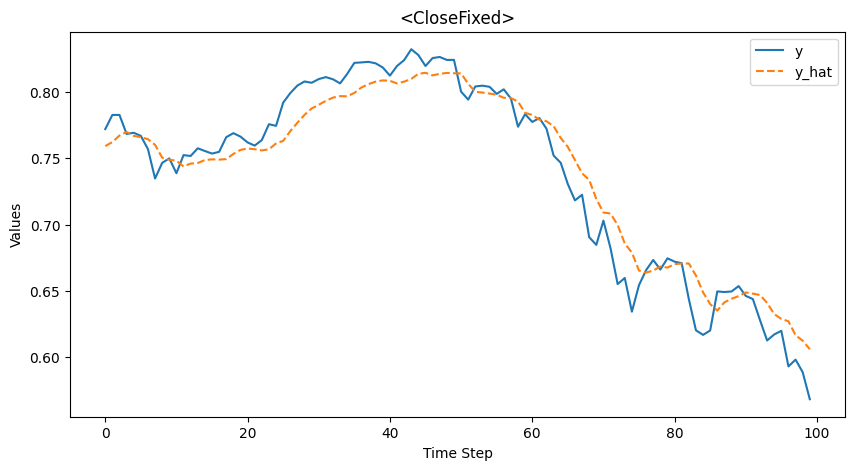

In [142]:
BiLSTM_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                            yhat=BiLSTM_uni2uni_manager.predict(uni2uni_loader.test_loader).cpu(),
                            feature_names=uni2uni_loader.out_features,
                            save_dir=os.path.join(plot_dir, sub_dir),
                            save_plots=True,
                            num_elements=ele)

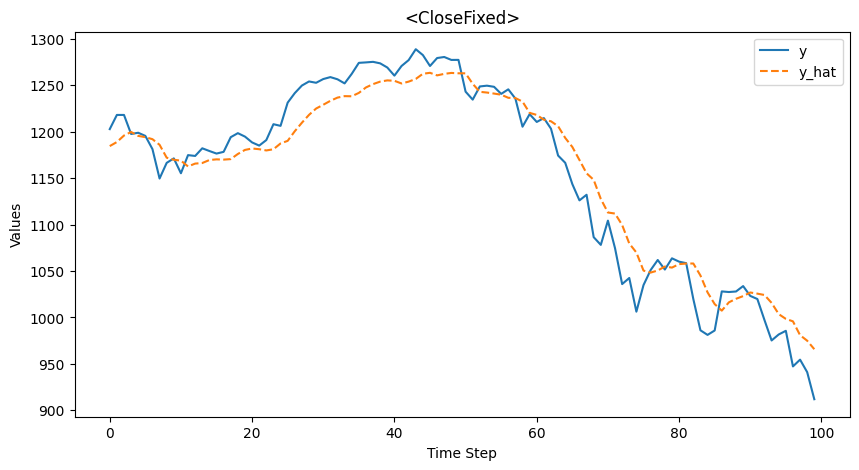

In [143]:
BiLSTM_uni2uni_manager.plot(y=inverse.inverse_transform(uni2uni_loader.y_test.reshape(-1, uni2uni_loader.y_test.shape[-1])).reshape(-1, 1, 1),
                         yhat=inverse.inverse_transform(BiLSTM_uni2uni_manager.predict(uni2uni_loader.test_loader).reshape(-1, uni2uni_loader.y_test.shape[-1]).cpu()).reshape(-1, 1, 1),
                         feature_names=uni2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

## XG BOOST

In [144]:
XGBoost_uni2uni = XGBRegressor(**xgboost_config)
XGBoost_uni2uni_manager = MachineLearningModelManager(model=XGBoost_uni2uni,
                                                      xtrain=uni2uni_loader.X_train,
                                                      ytrain=uni2uni_loader.y_train,
                                                      xval=uni2uni_loader.X_val,
                                                      yval=uni2uni_loader.y_val)
XGBoost_uni2uni_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": XGBoost_uni2uni_manager.evaluate(x=uni2uni_loader.X_test, y=uni2uni_loader.y_test)
})
results[-1]

[0]	validation_0-rmse:0.48352
[1]	validation_0-rmse:0.48016
[2]	validation_0-rmse:0.47682
[3]	validation_0-rmse:0.47353
[4]	validation_0-rmse:0.47026
[5]	validation_0-rmse:0.46703
[6]	validation_0-rmse:0.46383
[7]	validation_0-rmse:0.46065
[8]	validation_0-rmse:0.45752
[9]	validation_0-rmse:0.45439
[10]	validation_0-rmse:0.45137
[11]	validation_0-rmse:0.44831
[12]	validation_0-rmse:0.44532
[13]	validation_0-rmse:0.44239
[14]	validation_0-rmse:0.43949
[15]	validation_0-rmse:0.43656
[16]	validation_0-rmse:0.43366
[17]	validation_0-rmse:0.43086
[18]	validation_0-rmse:0.42810
[19]	validation_0-rmse:0.42529
[20]	validation_0-rmse:0.42252
[21]	validation_0-rmse:0.41984
[22]	validation_0-rmse:0.41708
[23]	validation_0-rmse:0.41436
[24]	validation_0-rmse:0.41176
[25]	validation_0-rmse:0.40906
[26]	validation_0-rmse:0.40651
[27]	validation_0-rmse:0.40399
[28]	validation_0-rmse:0.40133
[29]	validation_0-rmse:0.39887
[30]	validation_0-rmse:0.39630
[31]	validation_0-rmse:0.39396
[32]	validation_0-

{'Name': 'XGBRegressor', 'Type': 'uni2uni', 'MSE': 0.0008210791139479951}

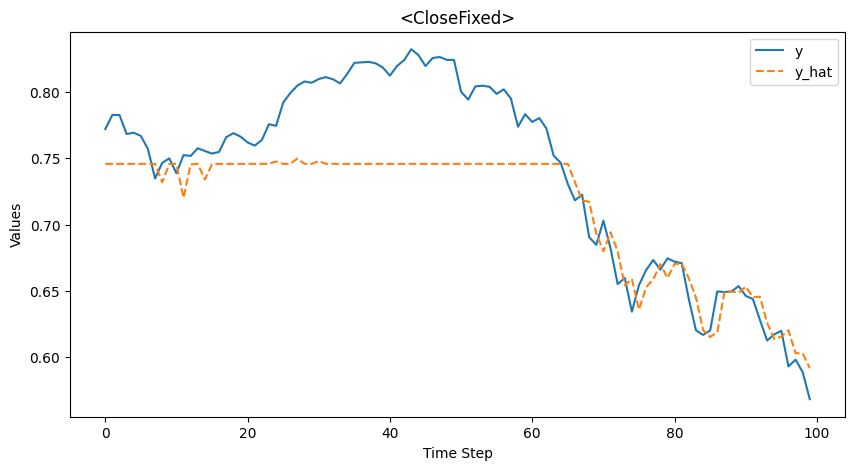

In [145]:
XGBoost_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                             yhat=XGBoost_uni2uni_manager.predict(uni2uni_loader.X_test),
                             feature_names=uni2uni_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

# **Multivariate-to-Univartiate**

In [174]:
features_type='MS'
sub_dir = 'multi2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2uni_loader = TimeSeriesDataLoader(file_path,
                                        input_size=input_size,
                                        label_size=label_size,
                                        offset=offset,
                                        train_size=train_size,
                                        val_size=val_size,
                                        target_name=target_name,
                                        features_type=features_type,
                                        date_column=date_column)

self.X_train.shape = (4657, 48, 2)
self.y_train.shape = (4657, 1, 1)
self.X_val.shape = (505, 48, 2)
self.y_val.shape = (505, 1, 1)
self.X_test.shape = (226, 48, 2)
self.y_test.shape = (226, 1, 1)


In [175]:
LSTM_multi2uni = LSTM(input_size=multi2uni_loader.in_variable,
                      hidden_size=hidden_size,
                      output_size=multi2uni_loader.out_variable,
                      ahead=label_size,
                      num_layers=num_layers)
LSTM_multi2uni_manager = ModelManager(model=LSTM_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
LSTM_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights\multi2uni\best-LSTM.pth
Epoch [1/1000000], time: 0s, loss: 0.0245, val_loss: 0.0212
Epoch [2/1000000], time: 0s, loss: 0.0567, val_loss: 0.2029
Epoch [3/1000000], time: 0s, loss: 0.0317, val_loss: 0.1161
Epoch [4/1000000], time: 0s, loss: 0.0269, val_loss: 0.0284
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [5/1000000], time: 0s, loss: 0.0163, val_loss: 0.0015
Epoch [6/1000000], time: 0s, loss: 0.0055, val_loss: 0.0052
Epoch [7/1000000], time: 0s, loss: 0.0057, val_loss: 0.0026
Epoch [8/1000000], time: 0s, loss: 0.0008, val_loss: 0.0019
Epoch [9/1000000], time: 0s, loss: 0.0007, val_loss: 0.0018
Epoch [10/1000000], time: 0s, loss: 0.0007, val_loss: 0.0016
Epoch [11/1000000], time: 0s, loss: 0.0007, val_loss: 0.0015
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [12/1000000], time: 0s, loss: 0.0006, val_loss: 0.0014
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [13/1000000], time: 0s, loss: 0.0006, val_loss: 0.0014
Model saved to weights\multi

{'Name': 'LSTM', 'Type': 'multi2uni', 'MSE': 0.0002242268064946984}

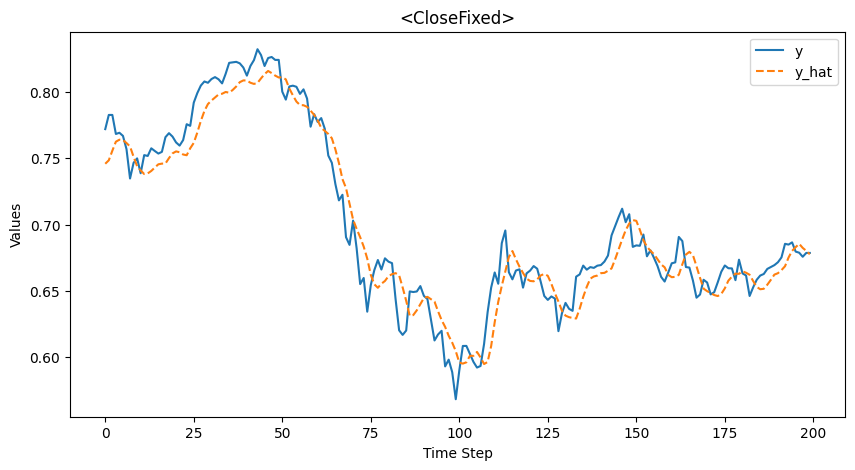

In [176]:
LSTM_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                            yhat=LSTM_multi2uni_manager.predict(multi2uni_loader.test_loader).cpu(),
                            feature_names=multi2uni_loader.out_features,
                            save_dir=os.path.join(plot_dir, sub_dir),
                            save_plots=True,
                            num_elements=ele)

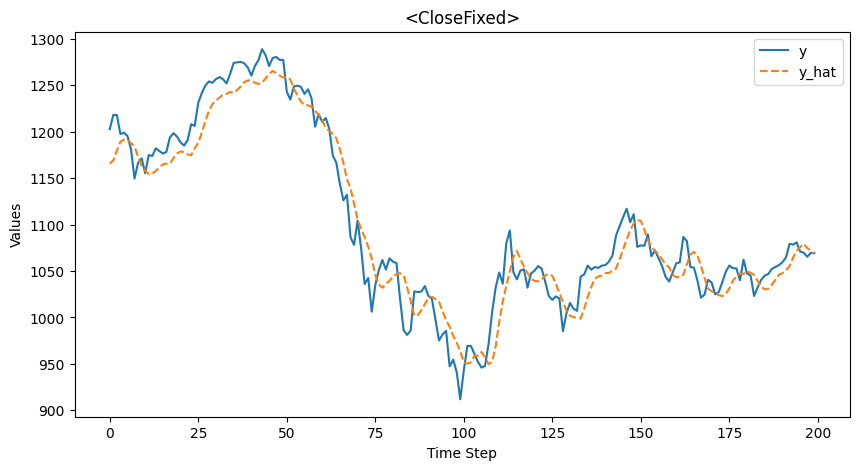

In [177]:
LSTM_multi2uni_manager.plot(y=inverse.inverse_transform(multi2uni_loader.y_test.reshape(-1, multi2uni_loader.y_test.shape[-1])).reshape(-1, 1, 1),
                         yhat=inverse.inverse_transform(LSTM_multi2uni_manager.predict(multi2uni_loader.test_loader).reshape(-1, multi2uni_loader.y_test.shape[-1]).cpu()).reshape(-1, 1, 1),
                         feature_names=multi2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

## BiLSTM

In [178]:
BiLSTM_multi2uni = BiLSTM(input_size=multi2uni_loader.in_variable,
                          hidden_size=hidden_size,
                          output_size=multi2uni_loader.out_variable,
                          ahead=label_size,
                          num_layers=num_layers)
BiLSTM_multi2uni_manager = ModelManager(model=BiLSTM_multi2uni,
                                        train_loader=multi2uni_loader.train_loader,
                                        val_loader=multi2uni_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)
BiLSTM_multi2uni_manager.train(num_epochs=num_epochs,
                               save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": BiLSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [1/1000000], time: 0s, loss: 0.0234, val_loss: 0.0185
Epoch [2/1000000], time: 0s, loss: 0.0477, val_loss: 0.0319
Epoch [3/1000000], time: 0s, loss: 0.0283, val_loss: 0.0418
Epoch [4/1000000], time: 0s, loss: 0.0141, val_loss: 0.0235
Epoch [5/1000000], time: 0s, loss: 0.0011, val_loss: 0.0250
Epoch [6/1000000], time: 0s, loss: 0.0007, val_loss: 0.0200
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [7/1000000], time: 0s, loss: 0.0004, val_loss: 0.0162
Epoch [8/1000000], time: 0s, loss: 0.0009, val_loss: 0.0168
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [9/1000000], time: 0s, loss: 0.0003, val_loss: 0.0131
Epoch [10/1000000], time: 0s, loss: 0.0008, val_loss: 0.0142
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [11/1000000], time: 0s, loss: 0.0004, val_loss: 0.0113
Epoch [12/1000000], time: 0s, loss: 0.0006, val_loss: 0.0116
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [13/1000000], time: 0s, lo

{'Name': 'BiLSTM', 'Type': 'multi2uni', 'MSE': 0.00017203284915012773}

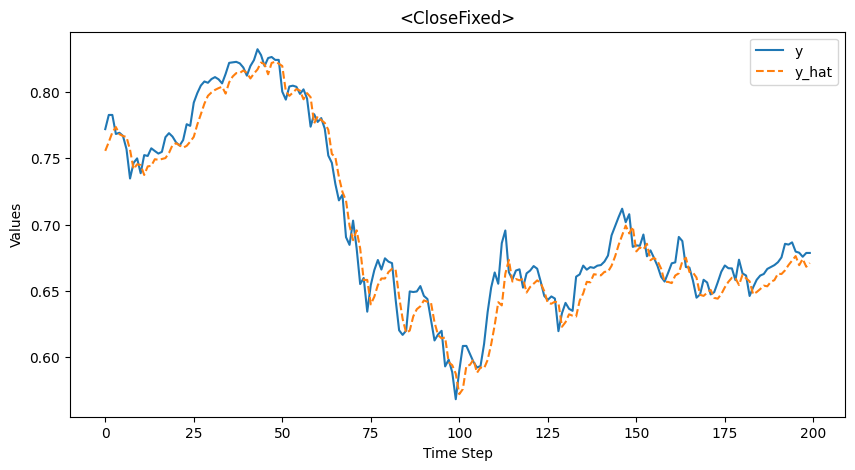

In [179]:
BiLSTM_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                              yhat=BiLSTM_multi2uni_manager.predict(multi2uni_loader.test_loader).cpu(),
                              feature_names=multi2uni_loader.out_features,
                              save_dir=os.path.join(plot_dir, sub_dir),
                              save_plots=True,
                              num_elements=ele)